In [10]:
# from generating_waveforms import SimInspiral
import lalsimulation as lalsim
import lal
import pycbc
from pycbc import waveform
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda
from timeit import default_timer as timer
from sklearn import preprocessing
from numba.core.errors import NumbaDeprecationWarning, NumbaWarning
import warnings
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaWarning)

# plt.switch_backend('WebAgg')
%matplotlib inline

%config IPCompleter.greedy=True

In [3]:
def SimInspiral(mass1, mass2, eccmin, freqmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    hp, hc = lalsim.SimInspiralTD(m1 = lal.MSUN_SI*mass1, m2 = lal.MSUN_SI*mass2, 
                              S1x = 0., S1y = 0., S1z = 0., 
                              S2x = 0., S2y = 0., S2z = 0.,
                              distance = 400.*1e6*lal.PC_SI, inclination = 0.,
                              phiRef = 0., longAscNodes = 0, eccentricity = eccmin, meanPerAno = 0.,
                              deltaT = DeltaT, f_min = freqmin, f_ref = freqmin,
                              LALparams = lalDict, approximant = lalsim.EccentricTD)
    
    hp_TS = pycbc.types.timeseries.TimeSeries(hp.data.data, delta_t=hp.deltaT)
    hc_TS = pycbc.types.timeseries.TimeSeries(hc.data.data, delta_t=hc.deltaT)
    epochTD = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9
    timesTD = np.arange(hp.data.length)*hp.deltaT + epochTD
    # np.savetxt('Straindata/SimInspiral_{}M_{}ecc.txt'.format((mass1 + mass2), eccmin), np.column_stack([timesTD,hp_TS,hc_TS]))

    # print("Absolute value of the maximum amplitude for M_tot = {}, eccmin = {}:".format((mass1 + mass2), eccmin),
    #       "\nh_x = ", abs(max(hc_TS)),
    #       "\nh_+ = ", abs(max(hp_TS)))
    phase = waveform.utils.phase_from_polarizations(hp_TS, hc_TS)
    
    return hp_TS, hc_TS


Note on eccentricTD that the phase drops at the start of the time-domain. Probably caused by time-derivatives in the phase calculations. This only happens for eccentric cases. No problems found in the non-eccentric case.


In [4]:
def SimInspiral_M_independent(total_mass, mass_ratio, eccmin, DeltaT = 1./2048., lalDict = lal.CreateDict()):
    """ Input: total_mass in M_sun, mass_ratio >= 1 (mass1 > mass2)
        Output: 
    
    """

    mass1 = total_mass/((1/mass_ratio) + 1)
    mass2 = total_mass - mass1

    # hp_TS, hc_TS = SimInspiral(mass1, mass2, eccmin, 50/total_mass)
    hp_TS, hc_TS = SimInspiral(mass1, mass2, eccmin, 5)
    # time_before_merger = abs(timesTD + timesTD[-1])
    


    hp_TS_over_M = hp_TS/total_mass
    hc_TS_over_M = hc_TS/total_mass

    t_M = -hp_TS.sample_times[::-1] / (lal.MTSUN_SI * total_mass )

    # norm_hp_TS_over_M = (hp_TS_over_M - hp_TS_over_M.min())/ (hp_TS_over_M.max() - hp_TS_over_M.min())
    # norm_hc_TS_over_M = (hc_TS_over_M - hc_TS_over_M.min())/ (hc_TS_over_M.max() - hc_TS_over_M.min())

    return hp_TS_over_M, hc_TS_over_M, t_M


In [43]:
def plot_Siminspiral_M_indp(M_total, mass_ratio, eccmin):
    """ Input: M_total: A list of total masses in solar mass, 
        mass_ratio: A list of mass ratio's for 0 <= q <= 1, 
        eccmin: A list of eccentricities for 0 <= e <= 1
    """
    fig_M = plt.figure(figsize=(8,3))
        

    for total_mass in M_total:
        for ratio in mass_ratio:
            for eccentricity in eccmin:

                start = timer()

                hp_TS_over_M, hc_TS_over_M, t_M = SimInspiral_M_independent(total_mass, ratio, eccentricity)
                phase = waveform.utils.phase_from_polarizations(hp_TS_over_M, hc_TS_over_M)

                plt.plot(t_M, hp_TS_over_M, label = 'Real: M = {} $(M_\odot)$, q = {}, e = {}'.format(total_mass, ratio, eccentricity), linewidth=0.6)
                # plt.plot(t_M, hc_TS_over_M, label = 'Imag: M = {} $(M_\odot)$, q = {}, e = {}'.format(total_mass, ratio, eccentricity), linewidth=0.6)
                # plt.xlim([-7e3, 5e2])
                # plt.legend(loc = 'upper left')
                plt.xlabel('t/M')
                plt.ylabel('h$_{+}$/M')
                plt.title('Waveform in units of mass')
                plt.grid()
                # plt.show()

                # plt.plot(t_M[:100], phase[:100])
                # plt.grid()
                # plt.show()

                print("time GPU:", (timer()-start)/60, ' minutes')
                print('M_total = {}; q = {}; eccmin = {}; Strain is calculated'.format(total_mass, ratio, eccentricity))
            
    figname = 'total mass = {}, mass ratio = {}, ecc = {}.png'.format(M_total, mass_ratio, eccmin)
    # fig.savefig('Images/' + figname)
    # print('fig is saved')


time GPU: 0.3981965316666901  minutes
M_total = 10; q = 1; eccmin = 0.01; Strain is calculated


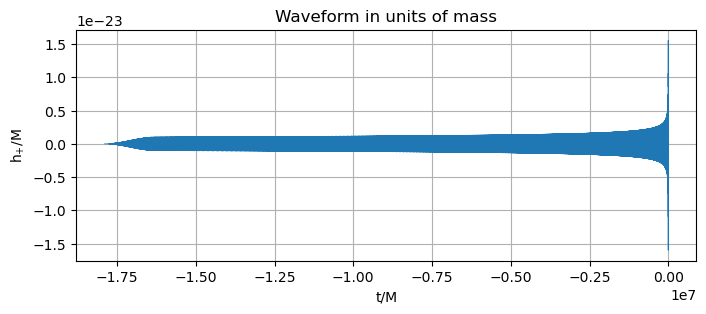

In [71]:
plot_Siminspiral_M_indp([10], [1], [0.01])
plt.show()

time GPU: 0.7946997900008379  minutes
Strain is calculated
time GPU: 1.2011422066667972  minutes
Strain is calculated
time GPU: 0.7819457500008866  minutes
Strain is calculated
time GPU: 0.7785314216666545  minutes
Strain is calculated
time GPU: 1.2015059116665119  minutes
Strain is calculated
time GPU: 0.77422819333345  minutes
Strain is calculated


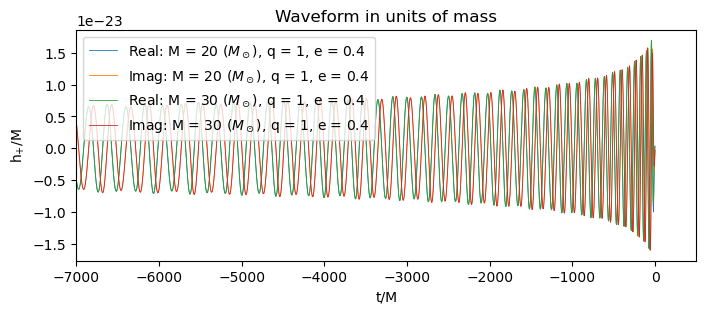

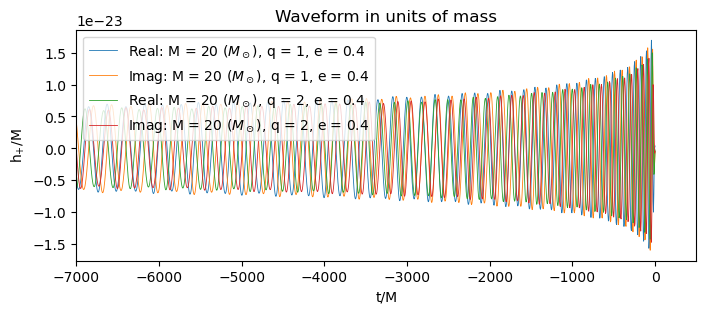

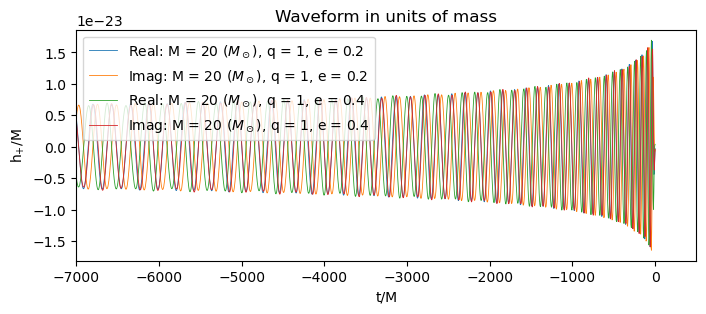

In [63]:
plot_Siminspiral_M_indp([20, 30], [1], [0.4])
plot_Siminspiral_M_indp([20], [1, 2], [0.4])
plot_Siminspiral_M_indp([20], [1], [0.2, 0.4])
plt.show()

Concluded from observation of GPU timer for different parameters:
- Higher eccentriricties have more cycles to mergers which results in longer inspiral times --> longer generation times
- Higher masses cause longer generation times so set M_total to a reasonably low value. M_total = 10
- Larger difference in mass ratio cause neglegible faster generation times, but does cause large irragularities to the waveform so set q = 1.

## Phase and amplitude difference for M_total = 10, q = 1

### Non-eccentric waveform and calculation of phase/amp difference

In [5]:
def circulair_wf(total_mass, mass_ratio):
    # Zero eccentricity
    hp_TS_circ, hc_TS_circ, t_M_circ = SimInspiral_M_independent(total_mass, mass_ratio, 1e-10)

    amp_circ = waveform.utils.amplitude_from_polarizations(hp_TS_circ, hc_TS_circ)
    phase_circ = waveform.utils.phase_from_polarizations(hp_TS_circ, hc_TS_circ)

    return amp_circ, phase_circ, t_M_circ

amp_circ, phase_circ, t_M_circ = circulair_wf(total_mass=10, mass_ratio=1) 


In [6]:

def phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):
    # insert eccmin as list
    start = timer()
    
    hp_TS, hc_TS, t_M = SimInspiral_M_independent(total_mass, mass_ratio, eccmin)
    print('time : SimInspiral_M_independent ecc = {}'.format(eccmin), (timer()-start)/60, ' minutes')
    
    amp = waveform.utils.amplitude_from_polarizations(hp_TS, hc_TS)
    phase = waveform.utils.phase_from_polarizations(hp_TS, hc_TS) 
    
    # phase += phase[1]# Correct for the small drop on the start of the time-domain
    # phase = phase[1:] # First element was already zero before translation so cut of the first element
    # amp = amp[1:]
    # t_M = t_M[1:] # Be consistent with te time-domain
    
    
    # Correct or longer time till merger in circulair case
    diff = phase_circ[len(phase_circ) - len(phase)]
    phase_circ = phase_circ - diff
    phase_circ = phase_circ[len(phase_circ) - len(phase):]
    # print('PHASE CIRC:', phase_circ[0:10])
    

    # Phase difference 
    D_phase = np.zeros(len(phase))

    for i in range(len(t_M)):
        D_phase[i] = phase[i] - phase_circ[i]
        
    D_amp = np.zeros(len(amp))

    for i in range(len(t_M)):
        D_amp[i] = amp[i] - amp_circ[i]


    return phase, D_phase, amp, D_amp, t_M, phase_circ, amp_circ, t_M_circ


time : SimInspiral_M_independent ecc = 0.01 0.5154970400000214  minutes


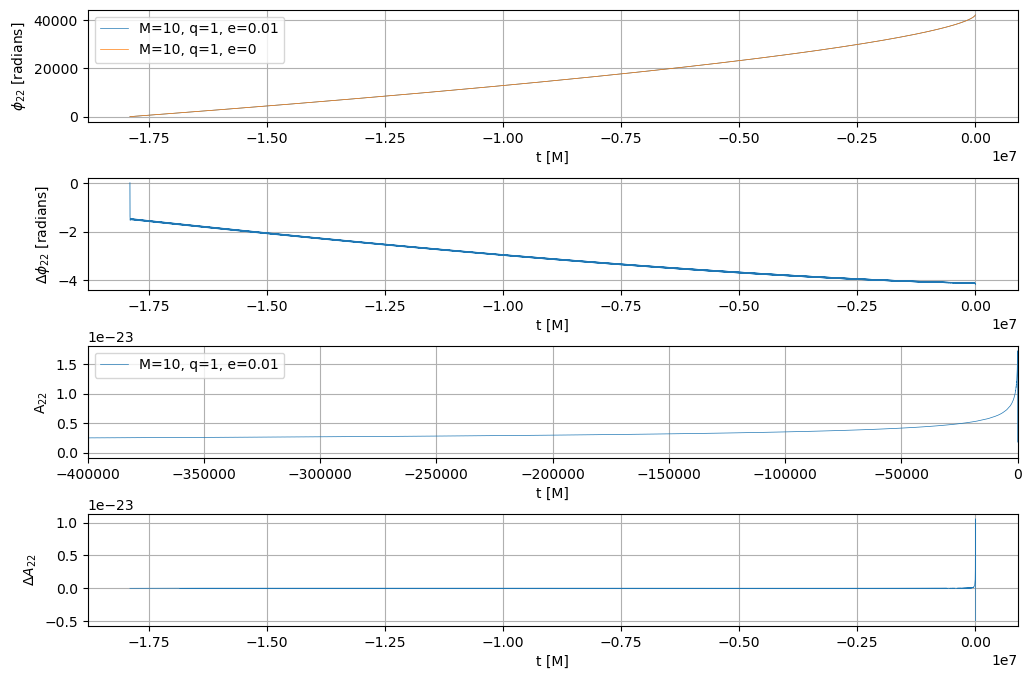

In [42]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)

    
    fig_phase_amp, axs = plt.subplots(4, 1, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times, phase, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    axs[0].plot(hp_times, phase_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')
    axs[0].grid()


    # # axs[1].plot(hp_circ_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[1].plot(hp_circ_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # axs[1].set_ylabel('$\phi$ [radians]')
    # # axs[0].set_xlim(-10000, 0)
    # # axs[0].set_ylim(2000, 4000)
    # axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')
    
    axs[1].plot(hp_times, D_phase, linewidth=0.6)
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    # axs[1].legend(loc='upper left')
    axs[1].grid()

    # axs[2].plot(hp_times, D_phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # axs[2].set_ylabel('$\Delta\phi$ [radians]')
    # axs[2].set_xlim(-400000, -380000)
    # axs[2].set_ylim(-1, 10)
    # axs[2].set_xlabel('t [M]')
    # axs[2].legend(loc='upper left')
    
    
    axs[2].plot(hp_times, amp, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    # axs[2].plot(hp_circ_times, amp_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    axs[2].set_ylabel('A$_{22}$')
    axs[2].set_xlim(-400000, 0)
    # axs[0][0].set_ylim(-6e-22, 6e-22)
    axs[2].set_xlabel('t [M]')
    axs[2].legend(loc='upper left')
    axs[2].grid()

    

    # # axs[2].plot(phase, amp, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('Amplitude')
    # # # axs[1].set_xlim(-20000, 0)
    # # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # # axs[2].set_xlabel('Phase [radians]')
    # # axs[2].legend(loc='upper left')


    axs[3].plot(hp_times, D_amp, linewidth=0.5)
    axs[3].set_ylabel('$\Delta A_{22}$')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[3].set_xlabel('t [M]')
    axs[3].grid()
    
    figname = 'phase22_Dphase22.png'
    fig_phase_amp.savefig('Images/' + figname)

Plot_phase_amplitude(10, 1, 0.1, amp_circ, phase_circ, t_M_circ)

### Drop in phase difference for low eccentricities (e =< 0.1))

time : SimInspiral_M_independent ecc = 0.1 0.5229278016666892  minutes


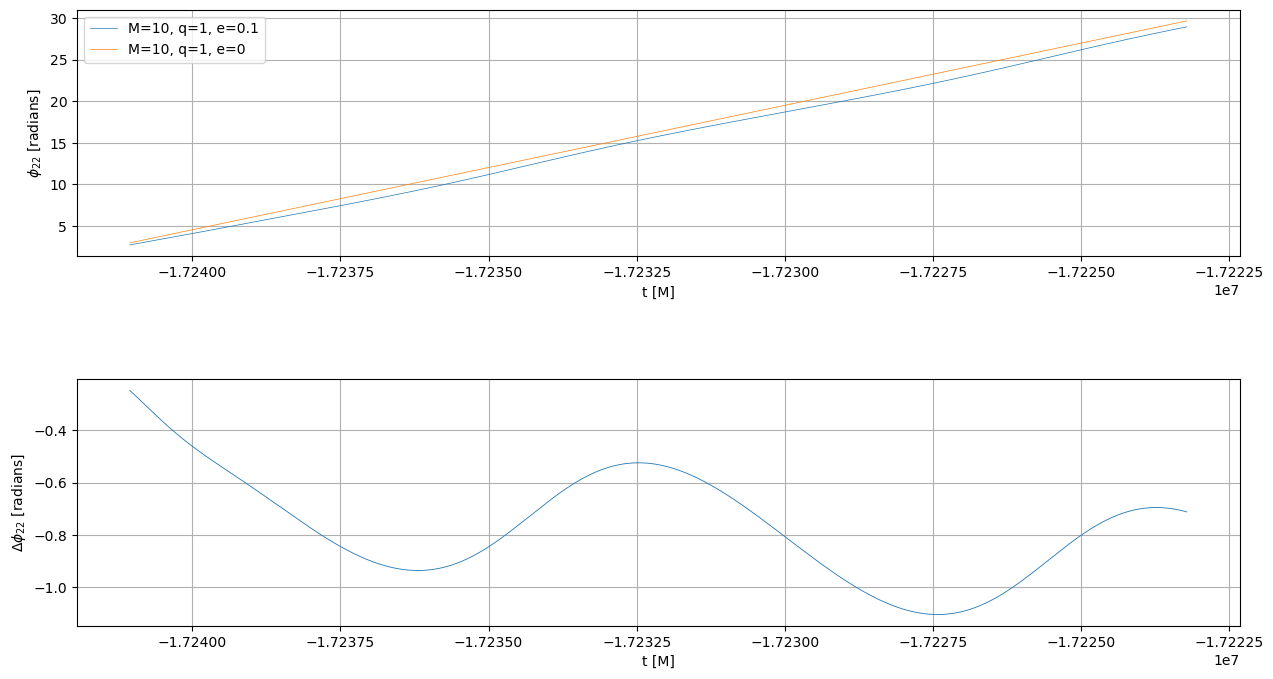

In [71]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)

    fig_phase_amp, axs = plt.subplots(2, figsize=(15, 8))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times[200:2000], phase[200:2000], label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    axs[0].plot(hp_times[200:2000], phase_circ[200:2000], label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].legend(loc='upper left')
    axs[0].grid()


    # # # axs[1].plot(hp_circ_times, phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[1].plot(hp_circ_times, phase_circ, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    # # axs[1].set_ylabel('$\phi$ [radians]')
    # # # axs[0].set_xlim(-10000, 0)
    # # # axs[0].set_ylim(2000, 4000)
    # # axs[1].set_xlabel('t [M]')
    # # axs[1].legend(loc='upper left')
    
    axs[1].plot(hp_times[200:2000], D_phase[200:2000], linewidth=0.6)
    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    # axs[1].legend(loc='upper left')

    # # axs[2].plot(hp_times, D_phase, label = 'M={}, q={}, e={}, f_min={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('$\Delta\phi$ [radians]')
    # # axs[2].set_xlim(-400000, -380000)
    # # axs[2].set_ylim(-1, 10)
    # # axs[2].set_xlabel('t [M]')
    # # axs[2].legend(loc='upper left')
    
    
    # axs[2].plot(hp_times, amp, label = 'M={}, q={}, e={}'.format(total_mass, mass_ratio, eccmin), linewidth=0.5)
    # # axs[2].plot(hp_circ_times, amp_circ, label = 'M={}, q={}, e=0'.format(total_mass, mass_ratio), linewidth=0.5)
    # axs[2].set_ylabel('A$_{22}$')
    # axs[2].set_xlim(-400000, 0)
    # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # axs[2].set_xlabel('t [M]')
    # axs[2].legend(loc='upper left')

    

    # # axs[2].plot(phase, amp, label = 'M={}, q={}, e={}, freqmin={}'.format(total_mass, mass_ratio, eccmin, freqmin), linewidth=0.5)
    # # axs[2].set_ylabel('Amplitude')
    # # # axs[1].set_xlim(-20000, 0)
    # # # axs[0][0].set_ylim(-6e-22, 6e-22)
    # # axs[2].set_xlabel('Phase [radians]')
    # # axs[2].legend(loc='upper left')


    # axs[3].plot(hp_times, D_amp, linewidth=0.5)
    # axs[3].set_ylabel('$\Delta A_{22}$')
    # # axs[1].set_xlim(-10000, 0)
    # # axs[1].set_ylim(400, 700)
    # axs[3].set_xlabel('t [M]')
    figname = 'phase22_Dphase22_start_cutoff.png'
    fig_phase_amp.savefig('Images/' + figname)

Plot_phase_amplitude(10, 1, 0.1, amp_circ, phase_circ, t_M_circ)

time : SimInspiral_M_independent ecc = 0.1 0.4608794900000551  minutes
index D_phase:  0.0
index D_phase:  -0.11804632904802226
index D_phase:  -0.24777797828809245
index D_phase:  -0.45020062480248235
index D_phase:  -0.6056391259540179
index D_phase:  -0.7618161431241379
index D_phase:  -0.8905123996699604
index D_phase:  -0.9354747490646993
index D_phase:  -0.8603277514584722
index D_phase:  -0.6934776035497272
last part of D_phase:  [   0.            0.74515507    0.73349403 ... -256.7340123  -256.73196689
 -256.73057129]


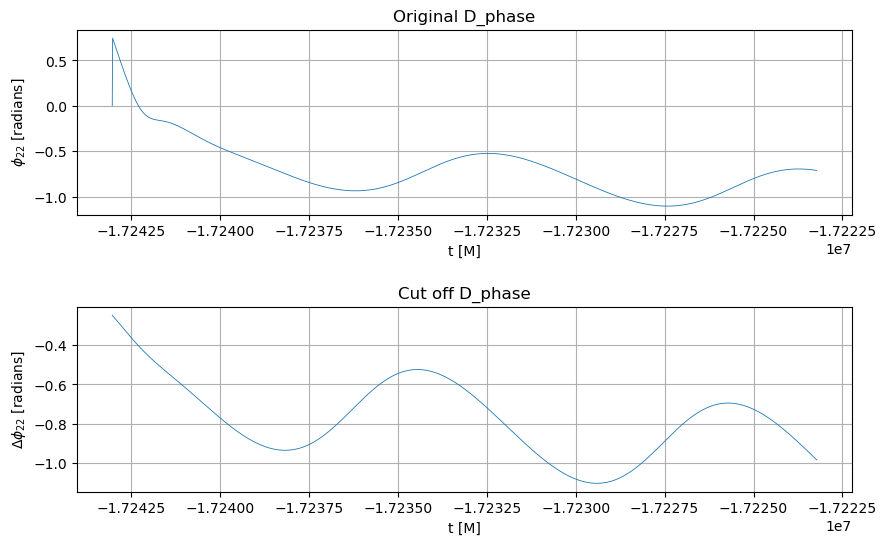

In [69]:
def Plot_phase_amplitude(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):

    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)
    
    for i in range(1000):
        if i % 100 == 0:
            print('index D_phase: ', D_phase[i])
    # print('start of cut-off D-phase:', D_phase[400:450])
    print('last part of D_phase: ', D_phase[:-100])
    
    fig_phase_amp, axs = plt.subplots(2, 1, figsize=(10, 6))
    plt.subplots_adjust(hspace=0.5)

    
    axs[0].plot(hp_times[0:2000], D_phase[0:2000], linewidth=0.6)
    # axs[0].plot(hp_times, phase_circ_short, label = 'M={}, q={}, e=0, f_min={}'.format(total_mass, mass_ratio, freqmin), linewidth=0.5)
    axs[0].set_ylabel('$\phi_{22}$ [radians]')
    # axs[0].set_xlim(-1.780e7, -1.770e7)
    # axs[0].set_ylim(-1, 1)
    axs[0].set_xlabel('t [M]')
    axs[0].set_title('Original D_phase')
    axs[0].grid()

    D_phase = D_phase[200:-100]
    axs[1].plot(hp_times[0:2000], D_phase[0:2000], linewidth=0.6)

    axs[1].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[1].set_xlim(-10000, 0)
    # axs[1].set_ylim(400, 700)
    axs[1].set_xlabel('t [M]')
    axs[1].set_title('Cut off D_phase')
    axs[1].grid()

    figname = 'phase22_Dphase22.png'
    fig_phase_amp.savefig('Images/' + figname)

Plot_phase_amplitude(10, 1, 0.1, amp_circ, phase_circ, t_M_circ)

From the plots it can be seen that there's a small drop in phase at the beginning of the time-domain. There's also a small drop at the end of the time-domain. To fix this problem I'll cut off the troubled parts at the start and end. Use the range **D_phase[200:-100]**

# Building the dataset

### Generate dataset for different eccentricities

time : SimInspiral_M_independent ecc = 0.1 0.6540020750000015  minutes


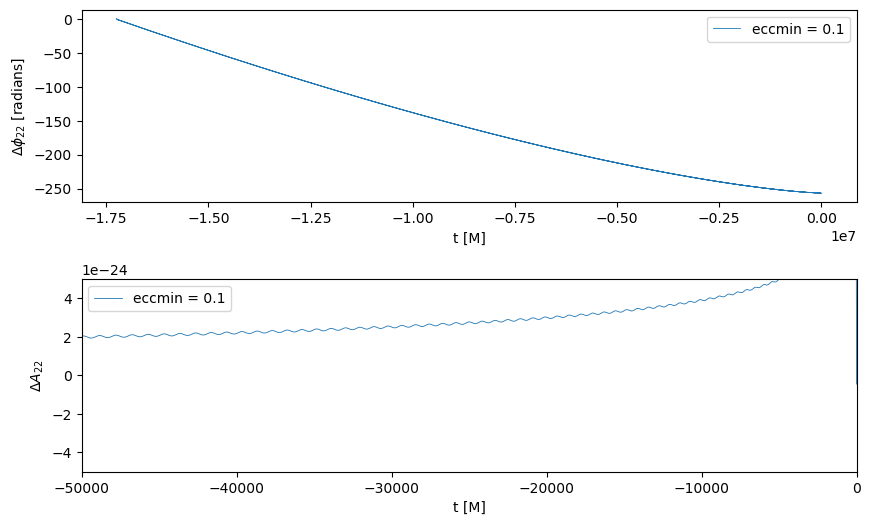

In [7]:
def phase_amp_diff(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ):
    
    phase, D_phase, amp, D_amp, hp_times, phase_circ, amp_circ, hp_circ_times = phase_amplitude_wf(total_mass, mass_ratio, eccmin, amp_circ, phase_circ, t_M_circ)
    

    
    axs[0].plot(hp_times, D_phase, linewidth=0.6, label = 'eccmin = {}'.format(eccmin))
    axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0].set_xlabel('t [M]')
    axs[0].legend()
    
    # axs[0][1].plot(hp_times, D_phase, linewidth=0.6)
    # axs[0][1].set_xlim(-10000, -2000)
    # axs[0][1].set_ylim(-300, -280)
    # axs[0][1].set_xlabel('t [M]')
    
    axs[1].plot(hp_times, D_amp, linewidth=0.6, label = 'eccmin = {}'.format(eccmin))
    axs[1].set_ylim(-0.5e-23, 0.5e-23)
    axs[1].set_xlim(-50000, 0)
    axs[1].set_ylabel('$\Delta A_{22}$')
    axs[1].set_xlabel('t [M]')
    axs[1].legend()
    
    # axs[1][1].plot(hp_times, D_amp, linewidth=0.6)
    # axs[1][1].set_xlim(-10000, -2000)
    # axs[1][1].set_xlabel('t [M]')

    return D_phase, D_amp, hp_times

fig_change, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

# Build dataset for different eccentricities
eccmin = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Different eccentricities cause different inspiral-times. Cut off the first part of every waveform so all waveforms have same length
D_phase, D_amp, t_M_short = phase_amp_diff(10, 1, np.max(eccmin), amp_circ, phase_circ, t_M_circ) # Highest eccentricity causes shortest inspiral-time.

# Cut off the first part (See section before about the drops)
t_M_short = t_M_short[200:]


In [8]:
# Make empty arrays to fill the complete dataset
D_phase_ds, D_amp_ds, t_M_ds, eccmin_ds = np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short))), np.zeros((len(eccmin), len(t_M_short)))

# Fill the last column with highest eccentricity 0.1
for i in range(len(t_M_short)): 
    D_phase_ds[-1][i] = D_phase[i]
    D_amp_ds[-1][i] = D_amp[i]
    t_M_ds[-1][i] = t_M_short[i]
    


In [9]:
print(eccmin[:5])
# Load first 5 eccentricities. Not all at once because of maximum memory error.
for wf_count, ecc in enumerate(eccmin[:5]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count][i] = D_phase[i]
        D_amp_ds[wf_count][i] = D_amp[i]
        t_M_ds[wf_count][i] = t_M[i]

print(D_phase_ds[0])

[0.01, 0.02, 0.03, 0.04, 0.05]
time : SimInspiral_M_independent ecc = 0.01 0.7322844083333317  minutes
time : SimInspiral_M_independent ecc = 0.02 0.7292877216666663  minutes
time : SimInspiral_M_independent ecc = 0.03 0.8453510916666649  minutes
time : SimInspiral_M_independent ecc = 0.04 0.6463599583333538  minutes
time : SimInspiral_M_independent ecc = 0.05 0.6889460083333385  minutes
[-1.62985193 -1.63000901 -1.63016557 ... -4.16438506 -4.16717759
 -4.17062937]


In [10]:
print(eccmin[-5:-1])
# Load last 4 eccentricities of eccmin range
for wf_count, ecc in enumerate(eccmin[-5:-1]):

    D_phase, D_amp, t_M = phase_amp_diff(10, 1, ecc, amp_circ, phase_circ, t_M_circ)
    length_diff = len(t_M) - len(t_M_short)

    # Cut off to match lengths with shortest waveform (e = 0.1)
    D_phase = D_phase[-len(t_M_short):]
    D_amp = D_amp[-len(t_M_short):]
    t_M = t_M[-len(t_M_short):]
    
    
    for i in range(len(t_M)): 

        D_phase_ds[wf_count + 5][i] = D_phase[i] # + 5 so wf_count starts from 5
        D_amp_ds[wf_count + 5][i] = D_amp[i]
        t_M_ds[wf_count + 5][i] = t_M[i]


[0.06, 0.07, 0.08, 0.09]
time : SimInspiral_M_independent ecc = 0.06 0.661919205000019  minutes
time : SimInspiral_M_independent ecc = 0.07 0.6465433416666504  minutes
time : SimInspiral_M_independent ecc = 0.08 0.6289913433333216  minutes
time : SimInspiral_M_independent ecc = 0.09 0.6119950966666693  minutes
[-1.62985193 -2.07969714 -1.76199381 -3.88715258 -4.57986735 -5.04979996
 -4.14733579 -4.75960287 -1.82684403  0.        ] [-1.62985193 -1.63000901 -1.63016557 ... -4.16438506 -4.16717759
 -4.17062937]


In [12]:
print(D_phase_ds)

[[  -1.62985193   -1.63000901   -1.63016557 ...   -4.16438506
    -4.16717759   -4.17062937]
 [  -2.07969714   -2.07969267   -2.0796907  ...  -12.52544735
   -12.54455624  -12.56858384]
 [  -1.76199381   -1.76235289   -1.76271453 ...  -24.83105781
   -24.85593601  -24.88734728]
 ...
 [  -4.75960287   -4.75990384   -4.76021436 ... -167.77280021
  -167.80465043 -167.84513525]
 [  -1.82684403   -1.82833925   -1.8298372  ... -208.74841901
  -208.77952959 -208.8180122 ]
 [   0.            0.74515507    0.73349403 ... -256.68240444
  -256.68539052 -256.68861763]]


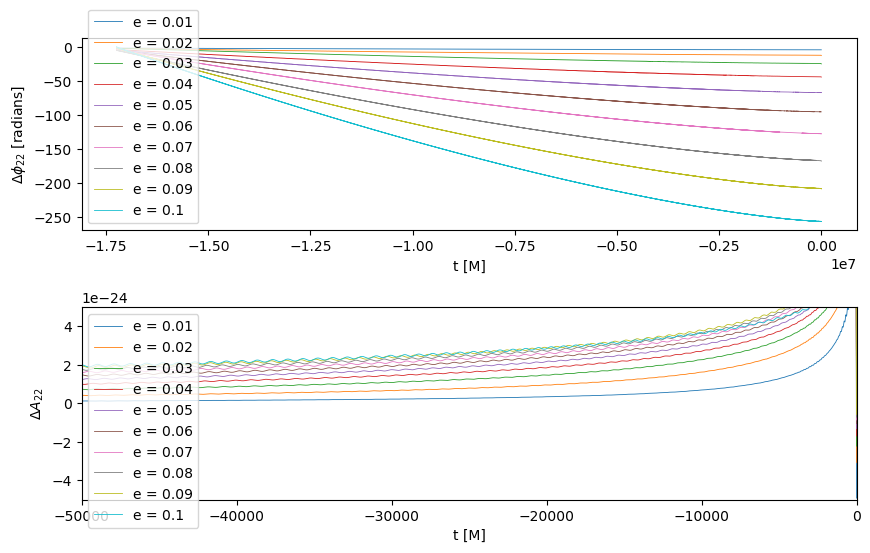

In [13]:


fig_dataset, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)


for i in range(len(D_phase_ds)):
    axs[0].plot(t_M_ds[i], D_phase_ds[i], linewidth=0.6, label = 'e = {}'.format(eccmin[i]))
    axs[0].set_xlabel('t [M]')
    axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    # axs[0].set_xlim(-50000, 0)
    axs[0].legend(loc = 'lower left')
    
    axs[1].plot(t_M_ds[i], D_amp_ds[i], linewidth=0.6, label = 'e = {}'.format(eccmin[i]))
    axs[1].set_ylabel('$\Delta A_{22}$')
    axs[1].set_ylim(-0.5e-23, 0.5e-23)
    axs[1].set_xlim(-50000, 0)
    axs[1].set_xlabel('t [M]')
    axs[1].legend(loc = 'upper left')  

plt.show()

### Save dataset in txt file

In [20]:
np.savetxt('Straindata/SimInspiral_t_M_test.txt', t_M_ds)
np.savetxt('Straindata/SimInspiral_Dphase_test.txt', D_phase_ds)
np.savetxt('Straindata/SimInspiral_Damp_test.txt', D_amp_ds)


In [11]:
# Read data from the text file
t_M_read = np.loadtxt('Straindata/SimInspiral_t_M_test.txt')
D_phase_read = np.loadtxt('Straindata/SimInspiral_Dphase_test.txt')
D_amp_read = np.loadtxt('Straindata/SimInspiral_Damp_test.txt')


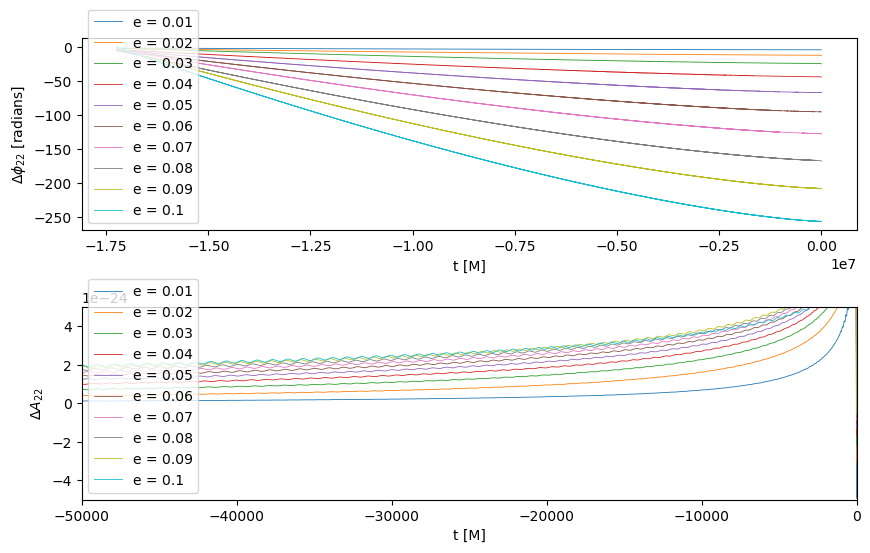

In [12]:
fig_dataset, axs = plt.subplots(2, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

eccmin = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

for i in range(len(t_M_read)):
    axs[0].plot(t_M_read[i], D_phase_read[i], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[0].set_xlabel('t [M]')
    axs[0].set_ylabel('$\Delta\phi_{22}$ [radians]')
    axs[0].grid()
    # axs[0].set_xlim(-50000, 0)
    axs[0].legend(loc = 'lower left')
    
    axs[1].plot(t_M_read[i], D_amp_read[i], label = 'e = {}'.format(eccmin[i]), linewidth=0.6)
    axs[1].set_ylabel('$\Delta A_{22}$')
    axs[1].set_ylim(-0.5e-23, 0.5e-23)
    axs[1].set_xlim(-50000, 0)
    axs[1].set_xlabel('t [M]')
    axs[1].grid()
    axs[1].legend(loc = 'lower left')
    
    figname = 'Dphase22_Damp22.png'
    fig_dataset.savefig('Images/' + figname)
    
plt.show()

# Reduced basis and greedy Error

In [146]:

def greedy_algorithm(parameter_space, waveforms, treshold_error = 1):
    # Import parameter space (N x 1) and waveforms (N x T)as array type. Where N is the amound of waveforms and T the length of the time-array.
    print(waveforms.shape, parameter_space.shape)
    
    num_waveforms = waveforms.shape[0]
    m = 0  # Initialize the counter for the number of reduced basis waveforms
    reduced_basis = np.zeros((waveforms.shape[1], num_waveforms))
    greedy_points = np.zeros((num_waveforms, parameter_space.shape[1]))

    # print(num_waveforms, reduced_basis.shape, greedy_points.shape)    
    #Randomly select the first waveform as the initial guess
    idx = np.random.choice(num_waveforms)
    reduced_basis[:, m] = waveforms[idx]
    greedy_points[m, :] = parameter_space[idx]

    greedy_error = 1
    while greedy_error >= treshold_error:
        
        # Calculate the projection coefficients for each waveform onto the current reduced basis
        coeffs = np.dot(waveforms, reduced_basis[:, :m+1])
        # print(waveforms, reduced_basis[:, :m+1], coeffs)
        
        #Calculate the residual for each waveform
        residuals = waveforms.T - np.dot(reduced_basis, coeffs)
        # print(residuals)
        
        # Find the index of the waveform that maximally contributes to the current residual
        idx = np.argmax(np.linalg.norm(residuals, axis=0))
        # print(idx)

        # Extract the selected waveform and add it to the reduced basis
        m += 1
        reduced_basis[:, m] = waveforms[idx]
        # print(reduced_basis)

        # Update the greedy points matrix
        greedy_points[m, :] = parameter_space[idx]
        # print(greedy_points)

        # # Check if the target representation accuracy is achieved
        greedy_error = np.linalg.norm(residuals[:, idx])
        print(greedy_error)
        
        break 
    return reduced_basis[:, :m+1], greedy_points[:m+1, :]

eccmin = np.array(eccmin)
eccmin = eccmin.reshape((eccmin.shape[0], 1))
                              
greedy_algorithm(eccmin, D_phase_read)

(10, 1739176) (10, 1)
6331828824759.982


(array([[ -3.88715258,  -1.62985193],
        [ -3.88649738,  -1.63000901],
        [ -3.88584027,  -1.63016557],
        ...,
        [-44.13991133,  -4.16438506],
        [-44.15504849,  -4.16717759],
        [-44.17465414,  -4.17062937]]),
 array([[0.04],
        [0.01]]))

In [139]:

def greedy_algorithm(parameter_space, waveforms, treshold_error = 1):
    # Import parameter space and waveforms as array type
    
    num_waveforms = waveforms.shape[0]
    m = 0  # Initialize the counter for the number of reduced basis waveforms
    reduced_basis = np.zeros((waveforms.shape[1], num_waveforms))
    greedy_points = np.zeros((num_waveforms, parameter_space.shape[1]))

    # print(num_waveforms, reduced_basis.shape, greedy_points.shape)    
    #Randomly select the first waveform as the initial guess
    idx = np.random.choice(num_waveforms)
    reduced_basis[:, m] = waveforms[idx]
    greedy_points[m, :] = parameter_space[idx]

    error = 1
    while error >= treshold_error:
        
        # Calculate the projection coefficients for each waveform onto the current reduced basis
        coeffs = np.dot(waveforms, reduced_basis[:, :m+1])
        # print(waveforms, reduced_basis[:, :m+1], coeffs)
        
        #Calculate the residual for each waveform
        residuals = waveforms.T - np.dot(reduced_basis, coeffs)
        # print(residuals)
        
        # Find the index of the waveform that maximally contributes to the current residual
        idx = np.argmax(np.linalg.norm(residuals, axis=0))
        # print(idx)

        # Extract the selected waveform and add it to the reduced basis
        m += 1
        reduced_basis[:, m] = waveforms[idx]
        # print(reduced_basis)

        # Update the greedy points matrix
        greedy_points[m, :] = parameter_space[idx]
        # print(greedy_points)

        # # Check if the target representation accuracy is achieved
        error = np.linalg.norm(residuals[:, idx])
        print(error)
        
        break 
    return reduced_basis[:, :m+1], greedy_points[:m+1, :]

eccmin = np.array(eccmin)
eccmin = eccmin.reshape((eccmin.shape[0], 1))
                              
greedy_algorithm(eccmin, D_phase_read)

201407075764449.25


(array([[   0.        ,   -1.62985193],
        [   0.74515507,   -1.63000901],
        [   0.73349403,   -1.63016557],
        ...,
        [-256.68240444,   -4.16438506],
        [-256.68539052,   -4.16717759],
        [-256.68861763,   -4.17062937]]),
 array([[0.1 ],
        [0.01]]))